In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, ConcatDataset
from pathlib import Path
from typing import Optional, Sequence
from PIL import Image, ImageDraw
import openslide
import PIL
import re
import os
import random
import numpy as np
import pandas as pd
import tqdm
from RetCLL import ResNet
import shutil
import matplotlib as plt
import math

In [4]:
SEED = 1234
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [126]:
class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, logits, label):
        log_prob = F.log_softmax(logits, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            label, 
            weight=self.weight,
            reduction = self.reduction
        )

In [ ]:
def npy_loader(path):
    x = np.load(path,allow_pickle=True).item()
    x_im = torch.from_numpy(x['features'])
    return x_im

def npy_loader_count(path):
    x = np.load(path,allow_pickle=True).item()
    x_im = torch.from_numpy(x['counts'])
    return x_im

In [127]:
class Attention(nn.Module):
    def __init__(self, L=2048, D=1024, dropout=True, n_classes=2, top_k=1):
        super(Attention, self).__init__()
        self.L = L
        self.D = D
        self.K = 1

        self.layer1 = nn.Linear(self.L, self.D)
        self.attention_V = nn.Sequential(nn.Linear(self.D, 512), nn.Tanh(), nn.Dropout(0.25))
        self.attention_U = nn.Sequential(nn.Linear(self.D, 512), nn.Sigmoid(), nn.Dropout(0.25))

        self.attention_weights = nn.Linear(512, self.K)

        self.classifier = nn.Sequential(nn.Linear(self.D, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.25),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,2),
                                        nn.Sigmoid())

        self.top_k = top_k

    def forward(self, x):
        x = self.layer1(x)
        A_V = self.attention_V(x)  # NxD
        A_U = self.attention_U(x)
        A = self.attention_weights(A_V * A_U)
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N
        M = torch.mm(A, x)  # KxL

        logits = self.classifier(M)
        y_probs = F.softmax(logits, dim=1)
        top_instance_idx = torch.topk(y_probs[:, 1], self.top_k, dim=0)[1].view(1, )
        top_instance = torch.index_select(logits, dim=0, index=top_instance_idx)
        Y_hat = torch.topk(top_instance, 1, dim=1)[1]
        Y_prob = F.softmax(top_instance, dim=1)
        results_dict = {}
        results_dict.update({'logits': top_instance, 'Y_prob': Y_prob, 'Y_hat': Y_hat, 'A': A})
        return A

    def relocate(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classifier.to(device)
        self.attention_V.to(device)
        self.attention_U.to(device)
        self.attention_weights.to(device)


In [129]:
class Attention_clam(nn.Module):
    def __init__(self, L=2048, D=1024, dropout=True, n_classes=2, top_k=1, instance_loss_fn=FocalLoss()):
        super(Attention_clam, self).__init__()
        self.L = L
        self.D = D
        self.K = 1

        self.layer1 = nn.Linear(self.L, self.D)
        if dropout:
            self.attention_V = nn.Sequential(nn.Linear(self.D, 512), nn.Tanh(), nn.Dropout(0.25))
            self.attention_U = nn.Sequential(nn.Linear(self.D, 512), nn.Sigmoid(), nn.Dropout(0.25))
        else:
            self.attention_V = nn.Sequential(nn.Linear(self.D, 512), nn.Tanh())
            self.attention_U = nn.Sequential(nn.Linear(self.D, 512), nn.Sigmoid())

        self.attention_weights = nn.Linear(512, self.K)

        self.classifier = nn.Sequential(nn.Linear(self.D, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.25),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(), 
                                        nn.Linear(512,2),
                                        nn.Sigmoid())
        self.top_k = top_k
        self.instance_loss = instance_loss_fn
        self.fc_X = nn.Sequential(nn.Linear(1, 2), nn.Sigmoid())
        self.fc_c = nn.Sequential(nn.Linear(4, 2), nn.Sigmoid())


    def relocate(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classifier.to(device)
        self.attention_V.to(device)
        self.attention_U.to(device)
        self.attention_weights.to(device)
        self.instance_loss.to(device)
        self.inst_eval.to(device)
        self.fc_c.to(device)
        self.fc_X.to(device)
    
    def inst_eval(self, A_T, count):
        logits_c = self.fc_c(count)
        hover_logits = torch.mm(A_T, logits_c)
        y_probs_c = F.softmax(logits_c, dim=1)
        k = math.ceil(logits_c.size()[0] / 20)
        _, predicted_class = torch.max(y_probs_c, dim=1)
        predicted_prob = y_probs_c[torch.arange(y_probs_c.size(0)), predicted_class]
        top_instance_idx = torch.topk(predicted_prob, 5, largest=True)[1]
        top_instance = torch.index_select(y_probs_c, dim=0, index=top_instance_idx)
        _, pseudo_targets = torch.max(top_instance, dim=1)

        A_T = torch.transpose(A_T, 1, 0)  # KxN
        logits_x = self.fc_X(A_T)
        y_probs_x = F.softmax(logits_x, dim=1)
        top_instance_x = torch.index_select(logits_x, dim=0, index=top_instance_idx)
        pseudo_logits = top_instance_x

        return pseudo_logits, pseudo_targets, hover_logits
    

    def forward(self, x, count):
        x = self.layer1(x)
        A_V = self.attention_V(x)  # NxD
        A_U = self.attention_U(x)
        A = self.attention_weights(A_V*A_U)
        A_T = torch.transpose(A, 1, 0)  # KxN
        A_T = F.softmax(A_T, dim=1)  # softmax over N
        M = torch.mm(A_T, x)  # KxL

        pseudo_logits, pseudo_targets, hover_logits = self.inst_eval(A_T, count)
        instance_loss = self.instance_loss(pseudo_logits, pseudo_targets)
       
        logits = self.classifier(M)
        y_probs = F.softmax(logits, dim=1)
        top_instance_idx = torch.topk(y_probs[:, 1], self.top_k, dim=0)[1].view(1, )
        top_instance = torch.index_select(logits, dim=0, index=top_instance_idx)
        Y_hat = torch.topk(top_instance, 1, dim=1)[1]
        Y_prob = F.softmax(top_instance, dim=1)
        results_dict = {}
        results_dict.update({'logits': top_instance, 'Y_prob': Y_prob, 'Y_hat': Y_hat, 'Instance_loss': instance_loss, 'hover_logits':hover_logits})

        return A_T

In [ ]:
class Attention_CMS(nn.Module):
    def __init__(self, L=2048, D=1024, dropout=True, n_classes=2, top_k=1):
        super(Attention_CMS, self).__init__()
        self.L = L
        self.D = D
        self.K = 1

        self.layer1 = nn.Linear(self.L, self.D)
        if dropout:
            self.attention_V = nn.Sequential(nn.Linear(self.D, 512), nn.Tanh(), nn.Dropout(0.25))
            self.attention_U = nn.Sequential(nn.Linear(self.D, 512), nn.Sigmoid(), nn.Dropout(0.25))
        else:
            self.attention_V = nn.Sequential(nn.Linear(self.D, 512), nn.Tanh())
            self.attention_U = nn.Sequential(nn.Linear(self.D, 512), nn.Sigmoid())

        self.attention_weights = nn.Linear(512, self.K)

        self.classifier = nn.Sequential(nn.Linear(1028,1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.25),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(), 
                                        nn.Linear(512,4),
                                        nn.Sigmoid())
        self.top_k = top_k
        self.instance_loss = nn.CrossEntropyLoss()
        self.fc_c1 = nn.Sequential(nn.Linear(4, 4), nn.ReLU())
        self.fc_X = nn.Sequential(nn.Linear(1, 4), nn.Sigmoid())

    def relocate(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classifier.to(device)
        self.attention_V.to(device)
        self.attention_U.to(device)
        self.attention_weights.to(device)
        self.instance_loss.to(device)
        self.fc_c1.to(device)
        self.fc_X.to(device)
    
    def inst_eval(self, A_T, count):
        logits_c = self.fc_c1(count)
        hover_logits = torch.mm(A_T, logits_c)
        y_probs_c = F.softmax(logits_c, dim=1)
        _, predicted_class = torch.max(y_probs_c, dim=1)
        predicted_prob = y_probs_c[torch.arange(y_probs_c.size(0)), predicted_class]
        top_instance_idx = torch.topk(predicted_prob, 5, largest=True)[1]
        top_instance = torch.index_select(y_probs_c, dim=0, index=top_instance_idx)
        _, pseudo_targets = torch.max(top_instance, dim=1)

        A_T = torch.transpose(A_T, 1, 0)  # KxN
        logits_x = self.fc_X(A_T)
        y_probs_x = F.softmax(logits_x, dim=1)
        top_instance_x = torch.index_select(logits_x, dim=0, index=top_instance_idx)
        pseudo_logits = top_instance_x

        return pseudo_logits, pseudo_targets,  hover_logits

    def forward(self, x, count, eval=False):
        x = self.layer1(x)
        A_V = self.attention_V(x)  # NxD
        A_U = self.attention_U(x)
        A = self.attention_weights(A_V*A_U)
        A_T = torch.transpose(A, 1, 0)  # KxN
        A_T = F.softmax(A_T, dim=1)  # softmax over N
        M = torch.mm(A_T, x)  # KxL

        pseudo_logits, pseudo_targets, hover_logits = self.inst_eval(A_T, count)
        instance_loss = self.instance_loss(pseudo_logits, pseudo_targets)

        M  = torch.cat((M, hover_logits), dim=1)
       
        logits = self.classifier(M)
        y_probs = F.softmax(logits, dim=1)
        max_scores, max_indice = torch.max(y_probs, dim=1)
        Y_hat = max_indice
        Y_prob = y_probs
       
        return A_T

In [131]:
test_dataset = pd.read_excel('/home/ldap_howard/script/CRC_CMS.xlsx', sheet_name='CMS_0604')
test_x = test_dataset['Patients'].values
test_y = test_dataset['status'].values
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:
model = Attention_CMS().to(device)
model.load_state_dict(torch.load('/home/ldap_howard/script/model/CMS_0307CV6_fold2_clam_checkpoint.pt'))

train_dir = '/ORCA_lake/TCGA-COAD/select_patches/CRC_DX_0307/'
save_dir = '/ORCA_lake/TCGA-COAD/high_attention/CRC_0307_HoverAtt_CMS/'
if os.path.exists(save_dir) == False: os.makedirs(save_dir)
CRC_count = pd.read_excel('/ORCA_lake/TCGA-COAD/hovernet/allqupath/CRC0307_patch_count.xlsx')
high_attention_list = []
model.eval()
with torch.no_grad():
    for slide_name, label in zip(test_x, test_y):
        print(slide_name)
        npy_dir = slide_name + '.npy'
        data = npy_loader(os.path.join('/ORCA_lake/TCGA-COAD/feature/CRC_resnet0307/', npy_dir)).to(device)
        count = npy_loader_count(os.path.join('/ORCA_lake/TCGA-COAD/hovernet_kmeans/CRC_0307_MI2N/', npy_dir)).to(device)
        attention_score = model(data, count)
        patches = pd.read_table('/ORCA_lake/TCGA-COAD/patch_list/CRC_DX_0307/'+slide_name+'_list.txt',header=None)

        _, top_indices = torch.topk(attention_score, k=5)
        connec, inflam, necros, neopla, nonneo = 0.0, 0.0, 0.0, 0.0, 0.0
        for index in top_indices[0]:
            patch = patches.iloc[index.item(),0]
            source_path = os.path.join(train_dir, slide_name)
            source_path = os.path.join(source_path, patch)
            save_name = slide_name + '_'+ patch
            slide_file = os.path.join(save_dir, slide_name)
            if os.path.exists(slide_file) == False: os.makedirs(slide_file)
            #target_path = os.path.join(save_dir, save_name)
            shutil.copy(source_path, slide_file)

            cell_count = CRC_count[(CRC_count['Patients'] == slide_name) & (CRC_count['Patch'] == patch.split('.')[0])].iloc[:,2:7].values
            #cell_count = np.concatenate((cell_count, np.array([[label]])), axis=1)
            #high_attention_list.extend(cell_count)
            connec += cell_count[0][0]
            inflam += cell_count[0][1]
            necros += cell_count[0][2]
            neopla += cell_count[0][3]
            nonneo += cell_count[0][4]
        
        cell_count_list = [slide_name, connec/5, inflam/5, necros/5, neopla/5, nonneo/5, label]
        high_attention_list.extend(cell_count_list)
    
    high_attention_list = np.array(high_attention_list).reshape(-1,7)
    high_attention_df = pd.DataFrame(high_attention_list, 
                                     columns=["Patients", "connec", "inflam","necros", "neopla", "no-neo", "Labels"])
    high_attention_df.to_excel('/ORCA_lake/TCGA-COAD/hovernet/allqupath/CRC0307_HoverAtt_CMS_top5.xlsx', index=False)


TCGA-T9-A92H-01Z-00-DX1
TCGA-AD-6895-01Z-00-DX1
TCGA-CA-6718-01Z-00-DX1
TCGA-WS-AB45-01Z-00-DX1
TCGA-5M-AAT6-01Z-00-DX1
TCGA-T9-A92H-01Z-00-DX2
TCGA-AD-6963-01Z-00-DX1
TCGA-F5-6814-01Z-00-DX1
TCGA-AA-3506-01Z-00-DX1
TCGA-AA-3845-01Z-00-DX1
TCGA-AA-3858-01Z-00-DX1
TCGA-CA-6717-01Z-00-DX1
TCGA-AG-3901-01Z-00-DX1
TCGA-AD-6899-01Z-00-DX1
TCGA-F4-6570-01Z-00-DX1
TCGA-A6-2686-01Z-00-DX1
TCGA-AG-A011-01Z-00-DX1
TCGA-DT-5265-01Z-00-DX1
TCGA-D5-6927-01Z-00-DX1
TCGA-CI-6624-01Z-00-DX1
TCGA-EI-7004-01Z-00-DX1
TCGA-D5-6928-01Z-00-DX1
TCGA-EI-6917-01Z-00-DX1
TCGA-G4-6628-01Z-00-DX1
TCGA-AY-4070-01Z-00-DX1
TCGA-AA-3952-01Z-00-DX1
TCGA-AH-6643-01Z-00-DX1
TCGA-AD-6964-01Z-00-DX1
TCGA-AA-3949-01Z-00-DX1
TCGA-AA-3655-01Z-00-DX1
TCGA-D5-6531-01Z-00-DX1
TCGA-A6-5662-01Z-00-DX1
TCGA-AD-6890-01Z-00-DX1
TCGA-AG-3887-01Z-00-DX1
TCGA-CI-6622-01Z-00-DX1
TCGA-D5-6930-01Z-00-DX1
TCGA-A6-6138-01Z-00-DX1
TCGA-AF-2687-01Z-00-DX1
TCGA-AA-3989-01Z-00-DX1
TCGA-AA-3984-01Z-00-DX1
TCGA-A6-6651-01Z-00-DX1
TCGA-DM-A285-01Z

## Important scores ##

In [5]:
from sklearn.svm import SVC
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [6]:
train_dataset = pd.read_excel('/ORCA_lake/TCGA-COAD/hovernet/allqupath/CRC0307_HoverAtt_CMS_top5.xlsx')
train_x = train_dataset.iloc[:, 1:6].values
train_y = train_dataset['Labels'].values

In [7]:
train_x

array([[ 7.8,  1.2,  9.6, 40.8,  0.6],
       [23.6,  0.2,  5.2, 29.8,  1.4],
       [18.2,  1.2,  1.6, 44.8,  0. ],
       ...,
       [ 8.6,  0.4, 44.8, 33.6,  0. ],
       [ 3.6,  0.2,  2.4, 39.4,  3.4],
       [ 3.2,  0. ,  7.6, 44. ,  0.6]])

In [8]:
train_y

array([0, 3, 2, 1, 1, 0, 1, 2, 1, 1, 1, 3, 2, 2, 1, 0, 1, 2, 1, 1, 0, 0,
       2, 1, 3, 0, 0, 1, 0, 3, 1, 1, 2, 1, 0, 1, 3, 2, 1, 1, 0, 1, 1, 3,
       1, 2, 1, 0, 0, 2, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1, 3, 3, 3, 1, 3, 1,
       1, 0, 0, 1, 0, 3, 2, 1, 1, 1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 0, 2, 1, 2, 1, 3, 3, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 1, 3, 0, 0, 2, 0, 3, 1, 1, 3, 0, 1, 3, 2, 1, 3,
       3, 1, 1, 0, 3, 3, 2, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 2, 3, 1, 1, 0,
       1, 3, 1, 3, 1, 2, 3, 3, 3, 2, 1, 3, 1, 2, 1, 1, 3, 0, 3, 0, 1, 3,
       1, 0, 1, 3, 2, 3, 0, 1, 3, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3,
       1, 2, 3, 3, 1, 2, 3, 1, 0, 2, 1, 3, 2, 3, 1, 1, 3, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 3, 3, 2, 1, 1, 1, 0, 1, 1, 2, 1,
       1, 0, 1, 2, 1, 0, 3, 1, 1, 2, 3, 3, 3, 0, 2, 3, 1, 1, 0, 3, 3, 2,
       3, 1, 1, 1, 0, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 2, 2, 2, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 3, 2, 1, 3, 3, 1, 1, 0, 3, 3,

## SVM ##

In [9]:
svm_model = SVC(kernel='linear')
svm_model.fit(train_x, train_y)
coefficients = svm_model.coef_[0]
coefficients


array([-0.00073183,  0.01545215,  0.01327638, -0.00344669,  0.01181437])

In [10]:
importance_scores = np.abs(coefficients)
importance_scores_normalized = importance_scores / np.sum(importance_scores)
importance_scores_normalized

array([0.01636425, 0.34552009, 0.2968684 , 0.07707029, 0.26417697])

In [11]:
scaler = StandardScaler()
importance_scores_standardized = scaler.fit_transform(coefficients.reshape(-1,1)).flatten()

print("Importance scores after standardization:", importance_scores_standardized)

Importance scores after standardization: [-1.02903526  1.0514767   0.77177295 -1.37804079  0.5838264 ]


Feature: 0, Score: 0.01636
Feature: 1, Score: 0.34552
Feature: 2, Score: 0.29687
Feature: 3, Score: 0.07707
Feature: 4, Score: 0.26418


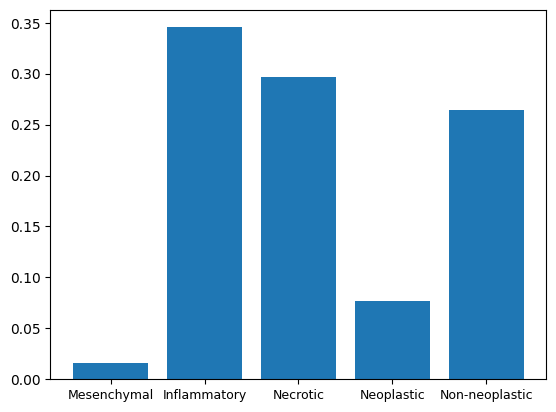

In [12]:
for i,v in enumerate(importance_scores_normalized):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feature_names = ["Mesenchymal", "Inflammatory","Necrotic", "Neoplastic", "Non-neoplastic"]
plt.bar([x for x in feature_names], importance_scores_normalized,)
plt.xticks(fontsize=9)
plt.show()

### Logisitc regrssion ###

Feature: 0, Score: 0.09926
Feature: 1, Score: 0.68055
Feature: 2, Score: 0.18662
Feature: 3, Score: 0.01843
Feature: 4, Score: 0.01514


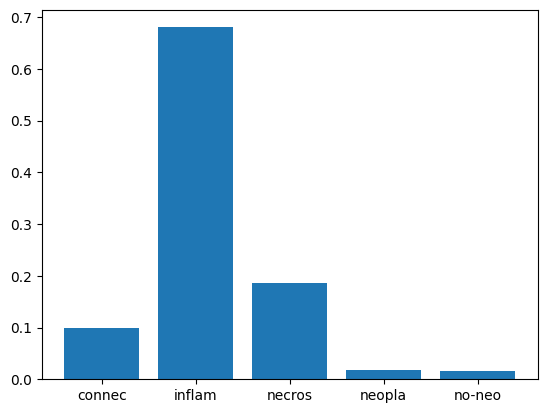

In [50]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_x, train_y)
importance = model.coef_[0]
importance_scores = np.abs(model.coef_[0])
importance_scores_normalized = importance_scores / np.sum(importance_scores)

importance_scores_standardized = scaler.fit_transform(importance.reshape(-1,1)).flatten()
for i,v in enumerate(importance_scores_normalized):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in feature_names], importance_scores_normalized)
plt.show()

## Random forest ##

Feature: 0, Score: 0.22183
Feature: 1, Score: 0.07309
Feature: 2, Score: 0.29306
Feature: 3, Score: 0.35799
Feature: 4, Score: 0.05402


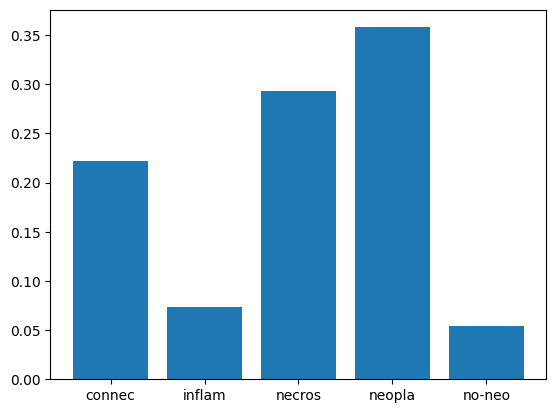

In [51]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(train_x, train_y)
importance = model.feature_importances_

for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in feature_names], importance)
plt.show()

## Plot slide numbers distribution ##

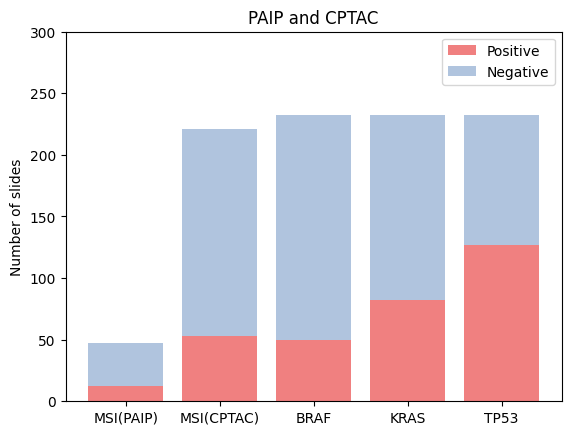

In [4]:
import matplotlib.pyplot as plt

# 資料集 A
PAIP_MSIH = 12
PAIP_MSS = 35

CPTAC_MSIH = 53
CPTAC_MSS = 168

# 資料集 B
BRAF_MUT = 50
BRAF_WT = 182

KRAS_MUT = 82
KRAS_WT = 150

TP53_MUT = 127
TP53_WT = 105

# 設定顏色
colors = ['lightsteelblue', 'lightcoral']
# 繪製長條圖
plt.bar(['MSI(PAIP)', 'MSI(CPTAC)', 'BRAF', 'KRAS', 'TP53'], [PAIP_MSIH, CPTAC_MSIH, BRAF_MUT, KRAS_MUT, TP53_MUT], color=colors[1], label='Positive')
plt.bar(['MSI(PAIP)', 'MSI(CPTAC)', 'BRAF', 'KRAS', 'TP53'], [PAIP_MSS, CPTAC_MSS, BRAF_WT, KRAS_WT, TP53_WT], color=colors[0], bottom=[PAIP_MSIH, CPTAC_MSIH, BRAF_MUT, KRAS_MUT, TP53_MUT], label='Negative')

# 加上標籤和圖例
#plt.xlabel('Data Sets')
plt.ylabel('Number of slides')
plt.ylim(0, 300)
plt.title('PAIP and CPTAC')
plt.legend()

# 顯示圖表
plt.show()